Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [91]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice, random
from copy import deepcopy
from math import factorial

from tqdm.auto import tqdm
import numpy as np

In [92]:
State = namedtuple('State', ['x', 'o'])

In [93]:
MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]

In [94]:
class Color:
    # Sequenze di escape ANSI per i colori del testo
    RESET = '\033[0m'
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'

In [95]:
def print_board(pos):
    """Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            i = r * 3 + c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    print()

In [96]:
def win(elements):
    """Checks is elements is winning"""
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    """Evaluate state: +1 first player wins"""
    if win(pos.x):
        return 1
    elif win(pos.o):
        return -1
    else:
        return 0
    
    

In [97]:
def random_game():
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    while available:
        x = choice(list(available))
        state.x.add(x)
        trajectory.append(deepcopy(state))
        available.remove(x)
        if win(state.x) or not available:
            break

        o = choice(list(available))
        state.o.add(o)
        trajectory.append(deepcopy(state))
        available.remove(o)
        if win(state.o):
            break
    return trajectory

In [98]:
"""value_dictionary = defaultdict(float)
hit_state = defaultdict(int)
epsilon = 0.001

for steps in tqdm(range(500_000)):
    trajectory = random_game()
    final_reward = state_value(trajectory[-1])
    for state in trajectory:
        hashable_state = (frozenset(state.x), frozenset(state.o))
        hit_state[hashable_state] += 1
        value_dictionary[hashable_state] = value_dictionary[
            hashable_state
        ] + epsilon * (final_reward - value_dictionary[hashable_state])"""

'value_dictionary = defaultdict(float)\nhit_state = defaultdict(int)\nepsilon = 0.001\n\nfor steps in tqdm(range(500_000)):\n    trajectory = random_game()\n    final_reward = state_value(trajectory[-1])\n    for state in trajectory:\n        hashable_state = (frozenset(state.x), frozenset(state.o))\n        hit_state[hashable_state] += 1\n        value_dictionary[hashable_state] = value_dictionary[\n            hashable_state\n        ] + epsilon * (final_reward - value_dictionary[hashable_state])'

In [99]:
alpha = 0.1
gamma = 0.98
fixed_epsilon = 0.2
# epsilon = fixed_epsilon
# GLIE approach
episodes = 20_000
k = episodes
eps_k = 0.1
b = (eps_k * k) // (1 - eps_k)

class agent:
  def __init__(self):
    # per ora la inizializzo a 0
    self.q_table = defaultdict(lambda: np.full(9, 0, dtype=float))
  
  def get_action(self, state, available_actions, epsilon=fixed_epsilon):
    '''print("Get : ")
    print(f"Epsilon : {epsilon}")'''
    if np.random.rand() < epsilon:
      action =  choice(available_actions)
      '''print(f"{Color.YELLOW}rand action: {action+1}{Color.RESET}")'''
      return action, available_actions
    else:
      hashable_state = (frozenset(state.x), frozenset(state.o))
      '''print(f"cumulative exp rew :\t{self.q_table[hashable_state][available_actions]}")'''
      best_action_index = np.argmax(self.q_table[hashable_state][available_actions])
      best_action_value = self.q_table[hashable_state][available_actions][best_action_index]
      best_action = list(available_actions)[best_action_index]
      '''print(f"{Color.GREEN}best action val:{best_action_value},\tbest action: {best_action+1}{Color.RESET}")'''
      return best_action, available_actions
  
  def update(self, state, action, reward, next_state, done):
    # print(f"action : {action}")
    '''print("Update : ")'''
    if done:
      target_value = reward
    else:
      hashable_next_state = (frozenset(next_state.x), frozenset(next_state.o))
      #print(f"max : {np.max(gamma * self.q_table[hashable_next_state])}")
      target_value = reward + np.max(gamma * self.q_table[hashable_next_state])
    
    '''print(f"t: {target_value}")'''
    
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.q_table[hashable_state][action] += (alpha * (target_value - self.q_table[hashable_state][action]))
    '''print(f"values : {self.q_table[hashable_state]}, value: {self.q_table[hashable_state][action]}")'''
    return
    
  def play(self, state, available_actions):
    hashable_state = (frozenset(state.x), frozenset(state.o))
    # print(f"cumulative exp rew :\t{self.q_table[hashable_state][available_actions]}")
    best_action_index = np.argmax(self.q_table[hashable_state][available_actions])
    best_action_value = self.q_table[hashable_state][available_actions][best_action_index]
    best_action = list(available_actions)[best_action_index]
    # print(f"{Color.GREEN}best action val:{best_action_value},\tbest action: {best_action+1}{Color.RESET}")
    available_actions.remove(best_action)
    return best_action, available_actions
  

In [100]:
def perform_action(action, available_actions, state, turn):
    done = False
    if turn == 0:
      state.o.add(action+1)
    else:
      state.x.add(action+1)
    available_actions.remove(action)
    if len(available_actions) == 0: done = True
    return state, done

target_vector = [2, 4, 6, 8]

def get_reward(state, done):
    if win(state.o):
      '''print("win: o")'''
      return -10, True
    reward = 0
    count_combinations = 0
    # if the action of x is blocking the winning of o => reward += 1
    for x in state.x:
      elements = list(state.o)
      elements.append(x)
      all_combinations = combinations(elements, 3)
      count_combinations += sum(1 for c in all_combinations if sum(c) == 15)
    reward += count_combinations

    reward += sum(1 for c in combinations(state.x, 3) if c in target_vector)
        
    if win(state.x):
      '''print("win: x")'''
      reward += 10
      return reward, True
    else:
      return reward, done
    

In [101]:
import matplotlib.pyplot as plt
# epsilon = fixed_epsilon
a = agent()
hist  = np.zeros(10)
for i in tqdm(range(10)):
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  turn = 1
  #turn = np.random.choice([0,1])
  '''print(f"starts: {'o' if turn == 0 else 'x'}")'''
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  epsilon = 0
  while not done:
    action, available_actions = a.get_action(state, available_actions, epsilon)
    # print(f"actual s: {state}")
    next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
    # print(f"turn: {'o' if turn == 0 else 'x'}")
    # print(f"action: {action+1}")
    # print(f"s:{state}, ns:{next_state}")
    '''print_board(state)
    print_board(next_state)'''
    turn = 1- turn
    # print(f"next s: {next_state}")
    reward, done = get_reward(next_state, done)
    a.update(state, action, reward, next_state, done)
    state = next_state
    '''print("----------------------------------------------")'''
    if reward == 1: hist[i] = 1
    #if done:  print_board(state)

  0%|          | 0/10 [00:00<?, ?it/s]

In [102]:
a = agent()
state = State(set(), set())
done = False
available_actions = list(range(9))
turn = 1
act = list()
while not done:
  action, available_actions = a.get_action(state, available_actions)
  '''print(f"actual s: {state}")'''
  next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
  act.append(action+1)
  '''print(f"turn: {'o' if turn == 0 else 'x'}")
  print(f"action: {action+1}")
  print_board(state)
  print_board(next_state)'''
  turn = 1- turn
  '''print(f"next s: {next_state}")'''
  reward, done = get_reward(next_state, done)
  '''if done: print("done")'''
  a.update(state, action, reward, next_state, done)
  state = next_state

'''print_board(state)
print(act)'''

'print_board(state)\nprint(act)'

## Training

In [103]:
import matplotlib.pyplot as plt
# epsilon = fixed_epsilon
a = agent()
hist  = np.zeros(episodes)
for i in tqdm(range(episodes)):
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  #turn = 1
  turn = np.random.choice([0,1])
  '''print(f"starts: {'o' if turn == 0 else 'x'}")'''
  state = State(set(), set())
  done = False
  available_actions = list(range(9))
  epsilon = b / (b + i)
  while not done:
    if turn == 1:
      # epsilon greedy player
      action, available_actions = a.get_action(state, available_actions, epsilon)
    else:
      # random player
      action = choice(available_actions)
    # print(f"actual s: {state}")
    next_state, done = perform_action(action, available_actions, deepcopy(state), turn)
    # print(f"turn: {'o' if turn == 0 else 'x'}")
    # print(f"action: {action+1}")
    # print(f"s:{state}, ns:{next_state}")
    # print_board(state)
    # print_board(next_state)
    # print(f"next s: {next_state}")
    reward, done = get_reward(next_state, done)
    a.update(state, action, reward, next_state, done)
    state = next_state
    if reward == 1: hist[i] = 1
    turn = 1- turn
    #if done:  print_board(state)

  0%|          | 0/20000 [00:00<?, ?it/s]

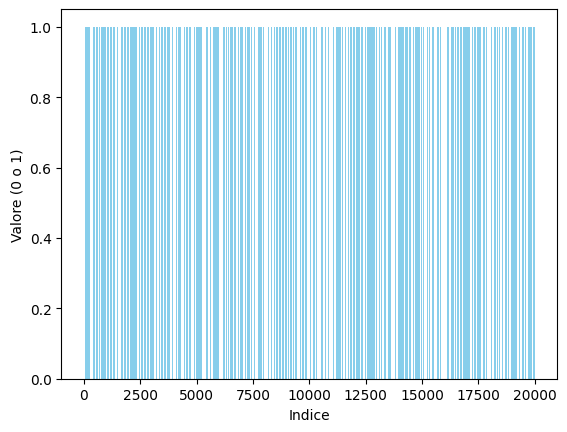

In [104]:
plt.bar(range(len(hist)), hist, color='skyblue')

# Imposta le etichette dell'asse x e y
plt.xlabel('Indice')
plt.ylabel('Valore (0 o 1)')

# Mostra il grafico
plt.show()

In [105]:

wins = 0
draws = 0
test = 1000
for _ in range(test):
    state = State(set(), set())
    available = list(range(9))
    # print(f"{[i+1 for i in available]}")
    trajectory = list()
    while available:
        x, available = a.play(state, available)
        # print(f"{[i+1 for i in available]} {x+1}")
        state.x.add(x+1)
        trajectory.append(deepcopy(state))
        if win(state.x):
            wins += 1
            print("x wins")
            break
        if not available:
            draws += 1
            print("draw")
            break
        
        o = choice(available)
        state.o.add(o+1)
        trajectory.append(deepcopy(state))
        available.remove(o)
        # print(f"{[i+1 for i in available]} {o+1}")
        if win(state.o):
            print("o wins")
            for t in trajectory:
                print_board(t)
            break
        if not available:
            draws += 1
            print("draw")
            break
    #print_board(state)
print(f"win rate: {wins/test}")
print(f"draw rate: {draws/test}")


x wins
draw
x wins
x wins
draw
o wins
...
.X.
...

...
OX.
...

...
OX.
..X

...
OX.
O.X

...
OXX
O.X

O..
OXX
O.X

x wins
x wins
x wins
x wins
x wins
o wins
...
.X.
...

..O
.X.
...

..O
XX.
...

O.O
XX.
...

O.O
XX.
X..

O.O
XXO
X..

O.O
XXO
XX.

O.O
XXO
XXO

draw
x wins
x wins
x wins
x wins
x wins
o wins
...
.X.
...

..O
.X.
...

..O
XX.
...

..O
XXO
...

..O
XXO
..X

.OO
XXO
..X

.OO
XXO
.XX

OOO
XXO
.XX

x wins
o wins
...
.X.
...

..O
.X.
...

..O
XX.
...

O.O
XX.
...

O.O
XX.
X..

OOO
XX.
X..

x wins
x wins
o wins
...
.X.
...

...
.X.
O..

X..
.X.
O..

X..
.X.
O.O

X..
XX.
O.O

X..
XX.
OOO

x wins
o wins
...
.X.
...

..O
.X.
...

..O
XX.
...

..O
XX.
..O

X.O
XX.
..O

X.O
XXO
..O

x wins
draw
x wins
x wins
x wins
draw
x wins
x wins
x wins
x wins
x wins
o wins
...
.X.
...

.O.
.X.
...

.OX
.X.
...

.OX
.X.
O..

XOX
.X.
O..

XOX
.X.
OO.

XOX
.XX
OO.

XOX
.XX
OOO

x wins
x wins
x wins
x wins
draw
draw
x wins
x wins
draw
x wins
x wins
x wins
x wins
o wins
...
.X.
...

.O.
.X.
...

.O